In [2]:
import networkx as nx
import numpy as np
import pandas as pd

import networkx.algorithms.community as nx_comm

import math


[3, 0, 3, 59, 2, 59, 16, 93, 0, 102, 0, 5, 85, 35, 38, 16, 13, 91, 55, 66, 15, 20, 15, 24, 36, 34, 28, 23, 80, 30, 54, 30, 12, 32, 53, 80, 48, 10, 92, 50, 43, 81, 32, 24, 24, 74, 86, 58, 32, 41, 39, 50, 39, 54, 77, 7, 69, 52, 47, 29, 65, 108, 57, 57, 11, 62, 47, 102, 63, 26, 4, 69, 7, 75, 38, 56, 103, 27, 71, 34, 17, 41, 61, 85, 92, 9, 85, 14, 45, 73, 53, 38, 77, 64, 19, 89, 19, 7, 104, 100, 87, 58, 67, 61, 84, 91, 56, 93, 43, 73, 87, 85, 80, 81, 51]
True
NMI
0.9937454980013586
MODULARITY: 
0.1005844015871452


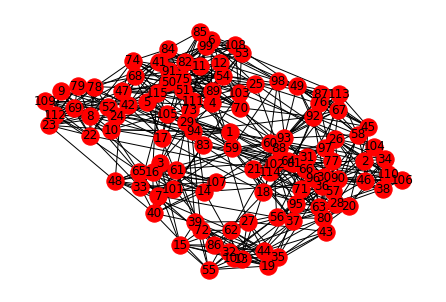

In [4]:





def entropy(nums):
    z = np.bincount(nums)
    N = len(nums)
    assert nums.shape == (N, )
    ent = 0.0
    for e in z:
        if e != 0:
            p = float(e) / N
            ent += p*math.log(p)
    assert ent <= 0
    ent = -ent

    assert ent >=0
    return ent
def computeNMI(clusters, classes):
    '''
    @ref: Page 359, An Introduction to Information Retrieval (by Stanford)
    compute Normalized Mutual Information from
    :param partitions: dictionary of vertex u and its community
    :param groundtruth: true community of vertex u.
    :return:
    '''

    assert clusters.shape == classes.shape
    A = np.c_[(clusters, classes)]
    A = np.array(A)
    N = A.shape[0]
    assert A.shape == (N, 2)

    H_clusters = entropy(A[:, 0])
    H_classes = entropy(A[:, 1])
    # print H_clusters
    # print H_classes
    # assert N == 17
    NMI = 0.0
    for k in np.unique(A[:, 0]):
        # get elements in second column that have first column equal to j
        z = A[A[:, 0] == k, 1]
        len_wk = len(z)
        t = A[:, 1]
        #for each unique class in z
        for e in np.unique(z):

            wk_cj=len(z[z==e])
            len_cj=len(t[t == e])
            assert wk_cj <= len_cj
            numerator= (float(wk_cj) / float(N)) * math.log( (N*wk_cj) / float(len_wk * len_cj)  )
            NMI += numerator
    NMI /= float((H_clusters + H_classes) * 0.5)

    assert (NMI > 0.0 or abs(NMI) < 1e-10) and (NMI < 1.0 or abs(NMI - 1.0) < 1e-10)
    return NMI



def check_res(res,Adj):
    print(res)
    for i in range(0,len(res)):
        if Adj[i,res[i]] ==0:
            return False
    return True





def community_detection(nodes,edges,population=15,generation=30,r=1.5):
    
    graph=nx.Graph() 
    graph.add_nodes_from(nodes) #adds nodes
    graph.add_edges_from(edges) #add edges
    Adj = nx.adjacency_matrix(graph) 
   
    nodes_length = len(graph.nodes())
    nx.draw(graph, with_labels=True,node_color = "red")
    d = {"chrom":[generate_chrom(nodes_length,Adj) for n in range(population)]}
      
    dframe = pd.DataFrame(data= d)
    
    
    dframe["f_score"]=dframe.apply(lambda x: f_score(x["chrom"],r,Adj),axis=1)

    
    gen = 0
    population_count = population
    while gen < generation:
        for i in range(int(np.floor(population/10))):
            elites = dframe.sort_values("f_score",ascending=False)[int(np.floor(population/10)):]
            for index , parent in elites.iterrows():
                av_index = [i for i in elites.index]
                av_index.remove(index)
                target = av_index[np.random.randint(0,len(av_index))]
                av_index.remove(target)
                
                random1 = av_index[np.random.randint(0,len(av_index))]
                av_index.remove(random1)
                
                
                random2 = av_index[np.random.randint(0,len(av_index))]
                av_index.remove(random2)

                
#                 print(index , ' ' , target , ' ' , random1 , ' ' , random2)
              
                trial = mutation(dframe.loc[index],dframe.loc[target],dframe.loc[random1],dframe.loc[random2],Adj,0.5)
#                 print(trial)
                offspring = crossover(parent, trial, 0.8)
    
                off_f_score = f_score(offspring, r , Adj)
                dframe.loc[population_count]=[offspring,off_f_score]
                population_count += 1
            
            
            
        dfsorted = dframe.sort_values("f_score",ascending=True)
        to_drop = dfsorted.index[population:]
        dframe.drop(to_drop,inplace=True)
        gen +=1   
#     print(dframe)
#     print(dfsorted)
#     print(dframe.sort_values("f_score",ascending=True))
    sorted_df = dframe.sort_values("f_score",ascending=True).index[0]
#     print('gnjgnioniogneiogeergnieginogrignigreio')
#     print(sorted_df)
    res = dframe.loc[sorted_df]
    
    
    
    res = res['chrom']
    
    istrue = check_res(res,Adj)
    print(istrue)
    
    res_subsets = find_subsets(res)
    
    nodes_subsets = res_subsets
    nodes_list = list(graph.nodes())
    result = []
    #print('nodeslist',nodes_list)
    for subs in nodes_subsets:
        subset = []
        for n in subs:
            subset.append(nodes_list[n])
        #print(subset)
        result.append(subset)
#     colors = ['red','blue','green','yellow','pink','orange','cyan','purple','grey','brown','olive','indigo','yellowgreen','chocolate']
#     alreadyvisited = []
#     k = 0 
#     colormap = ['']*result.size()
#     for i in result:
#         for j in i:
#             if j not in alreadyvisited:
#                 colormap[j] = colors[k]
#                 alreadyvisited.append(j)
#             else:
#                 colormap[j]=  'white'
#             j=j+1
#         k=k+1
#         i=i+1
#     nx.draw(graph,node_color = colormap , with_label = True)
#     plt.show()
    NMI = 0
    clu = dframe.loc[sorted_df]
    clu = clu['chrom']
    clu = np.array(clu)
    for index, target in dframe.iterrows():
        temp = np.array(target['chrom'])
        x = computeNMI(clu,temp)
        NMI += x
    NMI /= len(dframe)
    print('NMI')
    print(NMI)
    
    print('MODULARITY: ')
    
    modularity = nx_comm.modularity(graph, result)
    print(modularity)
    return result
































# returning the the array of column indexes where randomly chosen till value is 1 
def generate_chrom(nodes_length,Adj):
    chrom = np.array([],dtype=int)
    for x in range(nodes_length):
        rand = np.random.randint(0,nodes_length)
        while Adj[x,rand] != 1:
            rand = np.random.randint(0,nodes_length)
        chrom = np.append(chrom,rand)
    return chrom



def merge_subsets(sub):
    arr =[]
    to_skip=[]
    for s in range(len(sub)):
        if sub[s] not in to_skip:
            new = sub[s]
            for x in sub:
                if sub[s] & x:
                    new = new | x
                    to_skip.append(x)
            arr.append(new)
    return arr

def find_subsets(chrom):
    sub = [{x,chrom[x]} for x in range(len(chrom))]
    result=sub
    i=0
    while i<len(result):
        candidate = merge_subsets(result)
        if candidate != result:
            result = candidate
        else:
            break
        result=candidate
        i+=1
    return result

def f_score(chrom,r,Adj):
    score = 0
    for i in chrom:
        score += i*i;
    score /= len(chrom)
    return score

        
    
    

def roulette_selection(df_elites):
    prob = np.random.random_sample()
#     print('prob',prob)
    sum_cs=np.sum(df_elites["community_score"])
#     print(sum_cs)
    x=0
    selected = 0
    for i in df_elites.index:
        x += df_elites["community_score"][i]
            
        X=x/sum_cs
#         print('X',X)
        if prob < X:
            chosen=i
            break
    return chosen

def crossover(parent,trial,crossover_rate):
    if np.random.random_sample() >= crossover_rate:
        length = len(parent['chrom'])
        mask = np.random.randint(2, size=length)
        child = np.zeros(length,dtype=int)
        for i in range(len(mask)):
            if mask[i] == 1:
                child[i]=trial[i]
            else:
                child[i]=parent['chrom'][i]
        return child
    else:
        return trial
    
    
    

def mutation(parent , target , rand1 , rand2 ,Adj,mutation_rate):
    trial = []
   
    for i in range(0,len(parent['chrom'])):
        
        temp = target['chrom'][i] + mutation_rate*(rand1['chrom'][i] - rand2['chrom'][i])
        temp = int(temp)
#         print(temp)
        if temp < 0 or temp >= Adj.shape[0] or Adj[i,temp]==0:
            temp = target['chrom'][i]
        trial.append(temp)
    return trial
























nodes = []
edges = np.loadtxt('football.txt')
for i in edges:
    for j in i:
        if j not in nodes:
            nodes.append(int(j))
    

# print(nodes)
arr = community_detection(nodes,edges)


# print(arr)



#nx.draw_networkx_nodes(graph, arr[0], node_color="tab:blue")